In [92]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model
#import statsmodels.formula.api as smf
import statsmodels.api as sm
import directional # from https://github.com/calben/directionalstatspy/
from IPython.display import display

In [63]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file) for file in csv_files])
df_imported = df_imported.rename(columns={'Unnamed: 0': 'record_time'})
df_imported = df_imported.drop_duplicates(subset='record_time', keep='last')
df_imported = df_imported.set_index('record_time')
df_imported.count()

$                           152
dateStamp                    22
dew_point                   152
modelCode                    22
modelRun                     22
periodSchedule               22
pressure                    152
screen_relative_humidity    152
sea_temperature             152
surf_max                     22
surf_min                     22
swell_direction1             22
swell_direction2             22
swell_direction3             22
swell_height1                22
swell_height2                22
swell_height3                22
swell_period1                22
swell_period2                22
swell_period3                22
temperature                 152
wave_height                 152
wave_period                 152
wind_direction              152
wind_speed                  152
dtype: int64

available target values: 22
target values after interpolation: 143


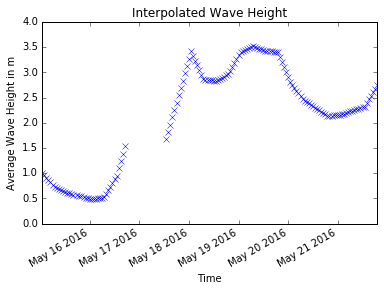

In [64]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
# fill NAs with linearly interpolated data
# TODO: Only for points which are max. 5h apart
s_target = s_target.interpolate()
print('target values after interpolation:', s_target.count())


def plot_datetime_series(series, title, xlabel='Time', ylabel='', label=['b-', 'g-', 'r-', 'y-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        plt.plot_date(
            matplotlib.dates.date2num(
                [dateutil.parser.parse(dt) for dt in s.index]
            ), 
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()
    
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', 'bx')

In [65]:
#directional.angle.radian_matrix_to_sin_cos_matrix(pd.DataFrame(df_explanatory['wind_direction']))?circular_example.drop
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            directional.angle.radian_matrix_to_sin_cos_matrix(df_radians[columns])
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[359.9, 359.9, 0.1, 0.1], 'other_data':[1,2,3,4]})
#display(circular_example)
#radians_example = pd.DataFrame({'radians': [deg * (math.pi / 180) for deg in circular_example['degrees']]})
#display(radians_example)
#display(directional.angle.radian_matrix_to_sin_cos_matrix(radians_example))

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))

,degrees,other_data
0,359.9,1
1,359.9,2
2,0.1,3
3,0.1,4


,other_data,degrees--SIN,degrees--COS
0,1,-0.001745,0.999998
1,2,-0.001745,0.999998
2,3,0.001745,0.999998
3,4,0.001745,0.999998


In [66]:
df_explanatory = df_imported[['wind_direction','dew_point', 'screen_relative_humidity', 'pressure', 'wind_speed', 'sea_temperature', 'temperature', 'wave_height', 'wave_period']]
df_explanatory = df_explanatory.dropna()
df_explanatory
display(df_explanatory['wind_direction'].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('becomes')
display(df_explanatory['wind_direction'].head())
print('becomes')
df_explanatory = degrees_to_sin_cos(df_explanatory, 'wind_direction')
display(df_explanatory.head())

record_time
2016-05-14T16:00:00+00:00     NW
2016-05-14T17:00:00+00:00    NNW
2016-05-14T18:00:00+00:00     NW
2016-05-14T19:00:00+00:00     NW
2016-05-14T20:00:00+00:00    WNW
Name: wind_direction, dtype: object

becomes


record_time
2016-05-14T16:00:00+00:00    315.0
2016-05-14T17:00:00+00:00    337.5
2016-05-14T18:00:00+00:00    315.0
2016-05-14T19:00:00+00:00    315.0
2016-05-14T20:00:00+00:00    292.5
Name: wind_direction, dtype: float64

becomes


,dew_point,screen_relative_humidity,pressure,wind_speed,sea_temperature,temperature,wave_height,wave_period,wind_direction--SIN,wind_direction--COS
record_time,,,,,,,,,,
2016-05-14T16:00:00+00:00,10.7,92.3,1023,4,12.7,11.9,1.1,6,-0.707107,0.707107
2016-05-14T17:00:00+00:00,10.8,91.6,1023,6,12.7,12.1,1.2,6,-0.382683,0.923880
2016-05-14T18:00:00+00:00,10.6,91.7,1023,5,12.9,11.9,1.0,5,-0.707107,0.707107
2016-05-14T19:00:00+00:00,10.5,91.6,1024,7,12.8,11.8,1.1,5,-0.707107,0.707107
2016-05-14T20:00:00+00:00,10.3,92.3,1024,7,12.8,11.5,1.1,6,-0.923880,0.382683


In [67]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
float64,dew_point
float64,screen_relative_humidity
int64,pressure
int64,wind_speed
float64,sea_temperature
float64,temperature
float64,wave_height
float64,wave_period
float64,wind_direction--SIN
float64,wind_direction--COS


In [68]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

dew_point                   143
screen_relative_humidity    143
pressure                    143
wind_speed                  143
sea_temperature             143
temperature                 143
wave_height                 143
wave_period                 143
wind_direction--SIN         143
wind_direction--COS         143
surf_avg                    143
dtype: int64

                              live
dew_point                -0.029375
screen_relative_humidity -0.200355
pressure                 -0.633520
wind_speed                0.744291
sea_temperature           0.352396
temperature               0.300867
wave_height               0.847364
wave_period              -0.012835
wind_direction--SIN      -0.361802
wind_direction--COS       0.194433


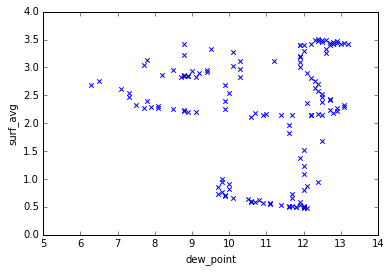

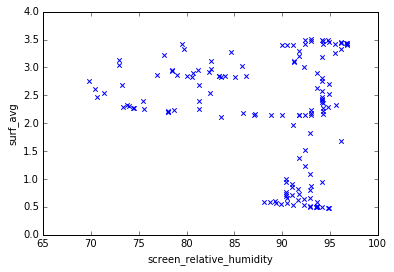

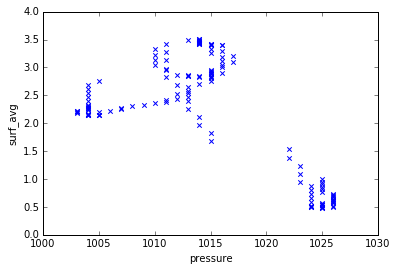

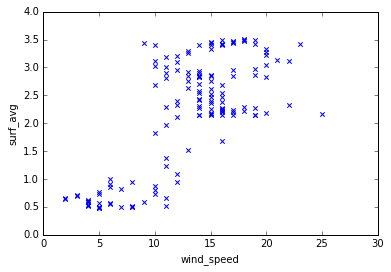

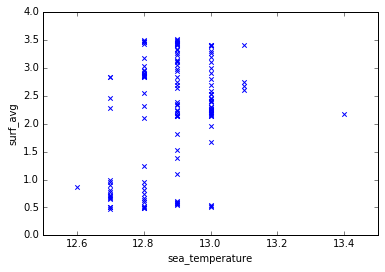

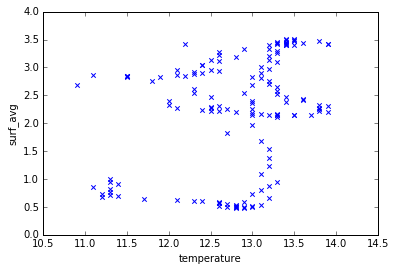

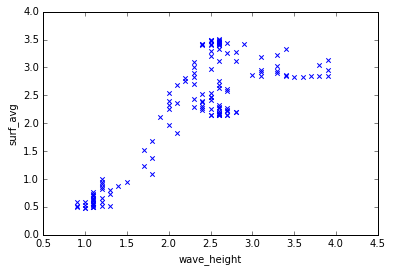

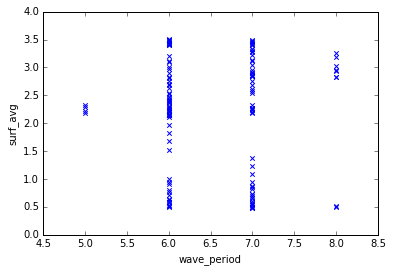

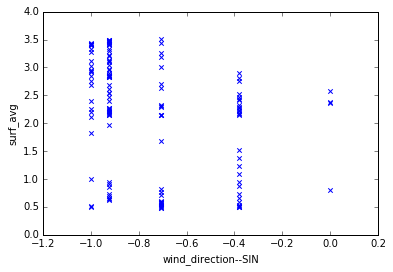

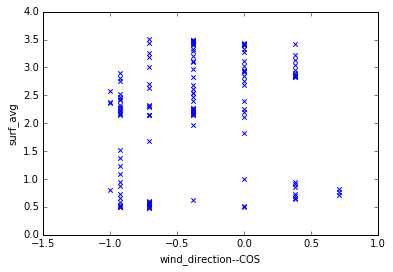

In [82]:
target_correlations = pd.Series([df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns])
target_correlations.name = 'live'
target_correlations = pd.DataFrame(target_correlations)
target_correlations.index = df_explanatory.columns
print(target_correlations)
#fix, axes =plt.subplots(nrows=len(df_explanatory.columns), figsize=(8,8))
for column in df_explanatory.columns:
    df_train.plot.scatter(x=column, y=target_var, marker='x')

In [83]:
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(2,23):
    target_correlations['ewma'+str(span)] = pd.Series([ pd.ewma(df_train[column], span=span).corr(df_train[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
target_correlations
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

,live,ewma2,ewma3,ewma4,ewma5,ewma6,ewma7,ewma8,ewma9,ewma10,...,ewma13,ewma14,ewma15,ewma16,ewma17,ewma18,ewma19,ewma20,ewma21,ewma22
dew_point,-0.029375,-0.024755,-0.020166,-0.015637,-0.011127,-0.006639,-0.002201,0.002152,0.006391,0.010496,...,0.021959,0.025515,0.028957,0.032298,0.035553,0.038733,0.041850,0.044914,0.047934,0.050916
screen_relative_humidity,-0.200355,-0.206773,-0.212866,-0.218955,-0.225058,-0.231221,-0.237507,-0.243971,-0.250647,-0.257549,...,-0.279530,-0.287209,-0.295018,-0.302926,-0.310906,-0.318930,-0.326974,-0.335017,-0.343037,-0.351017
pressure,-0.633520,-0.638368,-0.642631,-0.646520,-0.650097,-0.653409,-0.656500,-0.659401,-0.662134,-0.664711,...,-0.671528,-0.673490,-0.675294,-0.676939,-0.678425,-0.679754,-0.680931,-0.681962,-0.682852,-0.683610
wind_speed,0.744291,0.772186,0.787233,0.798625,0.808288,0.816853,0.824571,0.831554,0.837857,0.843514,...,0.856907,0.860279,0.863157,0.865575,0.867567,0.869164,0.870401,0.871306,0.871911,0.872245
sea_temperature,0.352396,0.394983,0.416761,0.431506,0.442707,0.451692,0.459117,0.465380,0.470762,0.475470,...,0.486926,0.490153,0.493177,0.496033,0.498747,0.501336,0.503816,0.506196,0.508487,0.510695
temperature,0.300867,0.321906,0.339304,0.355109,0.369963,0.384101,0.397608,0.410505,0.422795,0.434473,...,0.465857,0.475138,0.483863,0.492055,0.499742,0.506951,0.513712,0.520052,0.525999,0.531579
wave_height,0.847364,0.852611,0.855791,0.858751,0.861748,0.864791,0.867833,0.870814,0.873678,0.876376,...,0.883101,0.884808,0.886228,0.887357,0.888199,0.888760,0.889050,0.889083,0.888872,0.888434
wave_period,-0.012835,-0.009200,-0.003749,0.003060,0.011097,0.020158,0.030002,0.040389,0.051102,0.061956,...,0.094039,0.104282,0.114214,0.123809,0.133057,0.141954,0.150505,0.158719,0.166609,0.174188
wind_direction--SIN,-0.361802,-0.380233,-0.387406,-0.390353,-0.391078,-0.390387,-0.388702,-0.386287,-0.383325,-0.379952,...,-0.368240,-0.363993,-0.359635,-0.355187,-0.350669,-0.346094,-0.341471,-0.336812,-0.332121,-0.327408
wind_direction--COS,0.194433,0.191780,0.184253,0.174721,0.164009,0.152559,0.140670,0.128556,0.116375,0.104239,...,0.068785,0.057411,0.046289,0.035424,0.024816,0.014462,0.004360,-0.005496,-0.015113,-0.024496


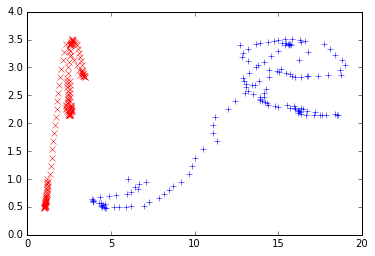

In [71]:
plt.plot(pd.ewma(df_train['wind_speed'], span=12), df_train[target_var], 'b+')
plt.plot(pd.ewma(df_train['wave_height'], span=12), df_train[target_var], 'rx')

In [72]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

coefficients:  [-2.77405747  0.51216628  0.01446272  0.01638189  0.51840957  3.11554028
  1.12682856 -0.14653672 -0.87201564  0.12340769]


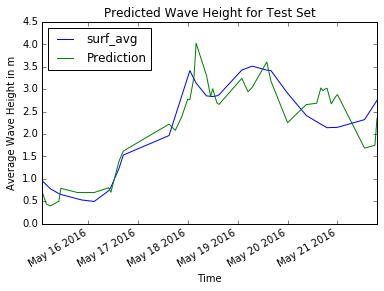

In [73]:
# perform predictionon unaveraged data
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset(df_train, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m')

coefficients:  [-3.93948164  0.69201949  0.04823671  0.09490581 -1.12009563  4.38797955
  0.81782581 -0.13758863 -2.33783381 -0.27498867]
intercept:  -110.711847172


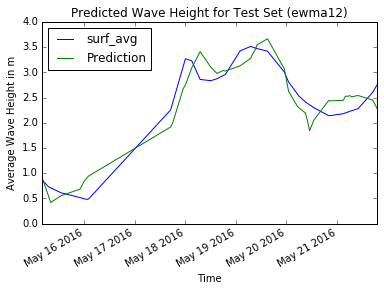

In [89]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset(df_ewma12, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)
predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set (ewma12)', 'Time', 'Average Wave Height in m')

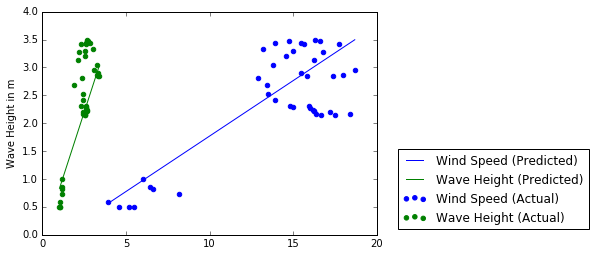

In [75]:
plt.scatter(
    test_set['wind_speed'],
    test_set[target_var],
    color='b'
)
plt.scatter(
    test_set['wave_height'],
    test_set[target_var],
    color='g'
)

predictions_wind_speed = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wind_speed'], name='Prediction').sort_index()
predictions_wave_height = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wave_height'], name='Prediction').sort_index()

plt.plot([test_set['wind_speed'].min(), test_set['wind_speed'].max()], [predictions_wind_speed.iloc[0], predictions_wind_speed.iloc[-1]])
plt.plot([test_set['wave_height'].min(), test_set['wave_height'].max()], [predictions_wave_height.iloc[0], predictions_wave_height.iloc[-1]])
plt.legend(['Wind Speed (Predicted)', 'Wave Height (Predicted)', 'Wind Speed (Actual)', 'Wave Height (Actual)'], bbox_to_anchor=(1.65, 0), loc='lower right')
plt.ylabel('Wave Height in m')

In [90]:
lm = sm.OLS(train_set[target_var], train_set[df_explanatory.columns]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     735.3
Date:                Sun, 22 May 2016   Prob (F-statistic):           1.96e-82
Time:                        00:11:42   Log-Likelihood:                -8.1184
No. Observations:                 101   AIC:                             36.24
Df Residuals:                      91   BIC:                             62.39
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
dew_point                   -0.1693      0.781     -0.217      0.829        -1.720     1.382
screen_relative_humidity     0.0318      0.135      0.235      0.815        -0.237     0.300
pressure                     0.0183      0.012      1.583      0.117        -0.005     0.041
wind_speed                   0.0709      0.029      2.411      0.018         0.012     0.129
sea_temperature             -2.4837      0.990     -2.509      0.014        -4.450    -0.517
temperature                  0.8688      0.886      0.981      0.329        -0.891     2.628
wave_height                  0.7691      0.177      4.336      0.000         0.417     1.121
wave_period                 -0.1303      0.165     -0.792      0.431        -0.457     0.197
wind_direction--SIN         -2.3078      0.380     -6.066      0.000        -3.064    -1.552
wind_direction--COS         -0.2160      0.306     -0.706      0.482        -0.824     0.392
==============================================================================
Omnibus:                        5.586   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                2.730
Skew:                           0.100   Prob(JB):                        0.255
Kurtosis:                       2.220   Cond. No.                     5.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R² value indicates that 98.8% of variance in the data are explained by the model. This is a good fit, but also may indicate overfit.

In [91]:
print('p value >= 0.5')
print(lm.pvalues.loc[[v >= 0.05 for v in lm.pvalues]])
print()
print('p value < 0.5')
print(lm.pvalues.loc[[v < 0.05 for v in lm.pvalues]])

p value >= 0.5
dew_point                   0.828833
screen_relative_humidity    0.814848
pressure                    0.116854
temperature                 0.329240
wave_period                 0.430639
wind_direction--COS         0.482004
dtype: float64

p value < 0.5
wind_speed             1.792133e-02
sea_temperature        1.388703e-02
wave_height            3.740858e-05
wind_direction--SIN    2.959436e-08
dtype: float64


P value greater than 0.05 means that it is likely that the feature has no importance for prediction. The coefficients 95% confidence interval includes zero.

H0 = There is no relationship between feature and target.

P value > 0.05 means we fail to reject the null hypothesis.